# Entrega laboratorio 2

## Integrantes 

- Javier Steven Barrera Toro - 202214779
- Julian Santiago Rolon Toloza - 202215839

In [32]:
from pyomo.environ import *

import numpy
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from typing import List
import numpy as np
from pyomo.environ import ConstraintList
from pyomo.opt import SolverFactory

# Punto 1

## 1.1. Preprocesamiento de los datos

Hay que hacer dos transformaciones que se realizarán posteriormente una vez se tenga el modelo matemático completamente planteado. Una de ellas es convertir las toneladas (multiplicar por 1000 las toneladas) a kilogramos y la otra es convertir el volumen de los recursos a unidades de volumen por kilogramo (como el volumen ya esta en $m^3$ solo hay que dividir entre el peso en $kg$ del recurso). En las siguientes secciones se detalla esto y se da un ejemplo.

### Conversión de toneladas a kilogramos

En la tabla original, los pesos de los recursos estaban dados en toneladas (TON), pero las capacidades de los aviones también estaban en toneladas. Para trabajar con valores más manejables y evitar confusiones en la implementación, se convirtió todo a kilogramos (1 TON = 1000 kg).

**Ejemplo:**  
El peso de los alimentos básicos es 15 TON, lo que equivale a 15000 kg.

### Cálculo del volumen por kilogramo

Originalmente, el volumen de los recursos se proporcionaba en metros cúbicos ($m^3$) por unidad de recurso. Como los recursos son divisibles (excepto los equipos médicos), se necesita expresar el volumen en función de cada kilogramo transportado.

Se obtiene dividiendo el volumen total entre el peso total:

$$
v_j = \frac{\text{Volumen Total}}{\text{Peso Total (kg)}}
$$

**Ejemplo:**  
Para los alimentos básicos, el volumen total es 8 $m^3$ y el peso total es 15000 kg. Entonces, el volumen por kg es:

$$
v_1 = \frac{8}{15000} \, m^3/\text{kg}
$$

## 1.2. Formulación del modelo matemático

### Conjuntos
- $F = F_1, F_2, F_3$ conjunto de los 3 aviones
- $R = R_1, \dots , R_5$ conjunto de los 5 recursos  

### Parámetros
- $W_i$ peso máximo que puede transportar el $i \in F$ avión
- $V_i$ volumen máximo que puede transportar el $i \in F$ avión
- $w_j$ peso del $j \in R$ recurso
- $v_j$ volumen del $j \in R$ recurso
- $p_j$ beneficio de llevar el $j \in R$ recurso

### Variables de decisión
- $X_{i,j}$ matriz de reales no negativos que indica cuanto se lleva del recurso $j \in R$ en el avión $i \in F$ en kilogramos.
- $Z_{i,j}$ matriz binaria que indica si el $i \in F$ avión llevan el $j \in R$ recurso. 

### Función objetivo
Se quiere maximizar el valor de los recursos que se llevan en la flota de aviones.
$$
\max \sum_{i \in F} \sum_{j \in R} X_{i,j} \times \frac{p_j}{m_j}
$$

### Restricciones
1. Cada uno de los aviones no puede llevar mas peso que su capacidad maxima.
$$
\sum_{j \in R} X_{i,j} \leq W_i, \forall i \in F
$$
2. Cada uno de los aviones no puede llevar mas volumen que su capacidad maxima.
$$
\sum_{j \in R} X_{i,j} \times v_j \leq V_i, \forall i \in F
$$
3. No se puede llevar una cantidad negativa de recursos.
$$
X_{i,j} \geq 0, \forall i \in F \,\,\, \forall j \in R
$$
4. No se pueden llevar mas recursos que los disponibles. Es decir, lo que se puede llevar en un avión no debe exceder la disponibilidad del recurso mismo
$$
\sum_{i \in F} X_{i,j} \leq w_j , \, \forall j \in R
$$
5. Los equipos medicos se tienen que llevar en unidades de 300 kg.
$$
X_{i,3} = 300 * Z_{i,3}, \forall i \in F 
$$
6. (Logistica 1) Las medicinas no pueden ir en el avión 1.
$$
X_{1,2} = 0
$$
7. (Logistica 2) El agua y los equipos medicos no pueden ir juntos en un avión para evitar contaminación cruzada. En este punto se puede optar por definir una variable auxiliar $Z$, que será una matriz binaria (0 y 1), de las dimensiones de $X$ tal que se almacena en la entrada $X_{i,j}$ si se lleva o no un recurso. De tal manera que se pueda realizar la restricción de manera más sencilla. 
$$
Z_{i,3} + Z_{i,4} \leq 1
$$

Al introducir esta variable auxiliar es necesario relacionarla con la variable objetivo. Por tanto, nacen dos restricciones mas: 1) Si $X_{i,j} > 0$, entonces $Z_{i,j} = 0$. 2) Si $X_{i,j} = 0$, entonces $Z_{i,j} = 0$.

### Tipo de problema

Este problema es de programación entera mixta (MIP). En particular notamos que es una variante del problema de asignación y mochila múltiple, donde se deben distribuir recursos en una flota de aviones respetando restricciones de peso, volumen y logística. Dado que hay variables continuas y binarias se clasifica como un problema de programación entera mixta (MIP).

## 1.3. Implementación en Pyomo

In [33]:
# Conjunto de aviones y recursos
F = [1, 2, 3]  # Aviones
R = [1, 2, 3, 4, 5]  # Recursos

# Parámetros
W = {1: 30000, 2: 40000, 3: 50000}  # Peso máximo por avión (kg)
V = {1: 25, 2: 30, 3: 35}  # Volumen máximo por avión (m³)
w = {1: 15000, 2: 5000, 3: 20000, 4: 18000, 5: 10000}  # Peso total disponible por recurso (kg)
v = {1: 8/15000, 2: 2/5000, 3: 10/20000, 4: 12/18000, 5: 6/10000}  # Volumen por kg
p = {1: 50, 2: 100, 3: 120, 4: 60, 5: 40}  # Beneficio por recurso

# Modelo
model = ConcreteModel()

# Variables de decisión
model.X = Var(F, R, domain=NonNegativeReals)  # Cantidad de recurso transportado (kg)
model.Z = Var(F, R, domain=Binary)  # Indica si un recurso es transportado

# Función objetivo: maximizar beneficio
model.obj = Objective(expr=sum(p[j] * model.X[i, j] for i in F for j in R), sense=maximize)

# Restricciones
# Capacidad de peso de cada avión
model.weight_constraint = ConstraintList()
for i in F:
    model.weight_constraint.add(sum(model.X[i, j] for j in R) <= W[i])

# Capacidad de volumen de cada avión
model.volume_constraint = ConstraintList()
for i in F:
    model.volume_constraint.add(sum(v[j] * model.X[i, j] for j in R) <= V[i])

# Disponibilidad de recursos
model.resource_constraint = ConstraintList()
for j in R:
    model.resource_constraint.add(sum(model.X[i, j] for i in F) <= w[j])

# Medicinas no pueden ir en el avión 1
model.medicine_constraint = Constraint(expr=model.X[1, 2] == 0)

# Equipos médicos indivisibles
model.medical_equipment_constraint = ConstraintList()
for i in F:
    model.medical_equipment_constraint.add(model.X[i, 3] == 300 * model.Z[i, 3])

# Incompatibilidad entre equipos médicos y agua potable
model.compatibility_constraint = ConstraintList()
for i in F:
    model.compatibility_constraint.add(model.Z[i, 3] + model.X[i, 4] <= 1)

# No negatividad ya está implícita en la declaración de variables

# Solver
solver = SolverFactory('glpk')
solver.solve(model)

# Resultados
beneficio_total = model.obj()
print(f'Beneficio total recolectado: {beneficio_total:.2f}')
for i in F:
    peso_total = sum(model.X[i, j].value for j in R if model.X[i, j].value > 0)
    volumen_total = sum(v[j] * model.X[i, j].value for j in R if model.X[i, j].value > 0)
    print(f'Avión {i} transporta {peso_total:.2f} kg con un volumen total de {volumen_total:.2f} m³')
    for j in R:
        if model.X[i, j].value > 0:
            print(f'    - {model.X[i, j].value:.2f} kg del recurso {j}')


Beneficio total recolectado: 1758000.00
Avión 1 transporta 25300.00 kg con un volumen total de 14.15 m³
    - 15000.00 kg del recurso 1
    - 300.00 kg del recurso 3
    - 10000.00 kg del recurso 5
Avión 2 transporta 5300.00 kg con un volumen total de 2.15 m³
    - 5000.00 kg del recurso 2
    - 300.00 kg del recurso 3
Avión 3 transporta 300.00 kg con un volumen total de 0.15 m³
    - 300.00 kg del recurso 3


## 1.4. Análisis de resultados

Beneficio total recolectado: 1758000.00
     Avión  Peso Transportado (kg)  Volumen Usado (m³)  \
0  Avión 1                   25300               14.15   
1  Avión 2                    5300                2.15   
2  Avión 3                     300                0.15   

   Capacidad Máxima Peso (kg)  Capacidad Máxima Volumen (m³)  
0                       30000                             25  
1                       40000                             30  
2                       50000                             35  


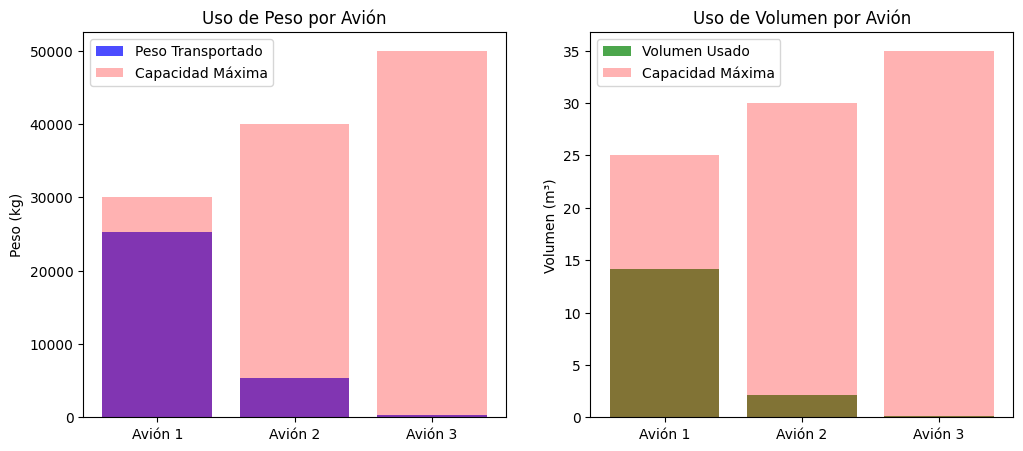


Conclusión:
- El beneficio total recolectado fue de 1,758,000.
- Se utilizó de manera eficiente la capacidad de peso de los aviones, aunque el volumen usado fue bajo.
- El avión 3 solo transportó 300 kg, lo que indica una subutilización.
- Se podría optimizar mejor la asignación de carga para maximizar la ocupación volumétrica.



In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Datos de los resultados
aviones = ['Avión 1', 'Avión 2', 'Avión 3']
peso_transportado = [25300, 5300, 300]
volumen_usado = [14.15, 2.15, 0.15]
capacidad_peso = [30000, 40000, 50000]
capacidad_volumen = [25, 30, 35]

# Beneficio total obtenido
beneficio_total = 1758000

# Crear un DataFrame
resultados_df = pd.DataFrame({
    'Avión': aviones,
    'Peso Transportado (kg)': peso_transportado,
    'Volumen Usado (m³)': volumen_usado,
    'Capacidad Máxima Peso (kg)': capacidad_peso,
    'Capacidad Máxima Volumen (m³)': capacidad_volumen
})

# Mostrar los resultados
print(f"Beneficio total recolectado: {beneficio_total:.2f}")
print(resultados_df)

# Visualización del uso de peso y volumen
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de barras para peso transportado
ax[0].bar(aviones, peso_transportado, color='b', alpha=0.7, label='Peso Transportado')
ax[0].bar(aviones, capacidad_peso, color='r', alpha=0.3, label='Capacidad Máxima')
ax[0].set_ylabel('Peso (kg)')
ax[0].set_title('Uso de Peso por Avión')
ax[0].legend()

# Gráfico de barras para volumen usado
ax[1].bar(aviones, volumen_usado, color='g', alpha=0.7, label='Volumen Usado')
ax[1].bar(aviones, capacidad_volumen, color='r', alpha=0.3, label='Capacidad Máxima')
ax[1].set_ylabel('Volumen (m³)')
ax[1].set_title('Uso de Volumen por Avión')
ax[1].legend()

plt.show()

# Conclusión
conclusion = """
Conclusión:
- El beneficio total recolectado fue de 1,758,000.
- Se utilizó de manera eficiente la capacidad de peso de los aviones, aunque el volumen usado fue bajo.
- El avión 3 solo transportó 300 kg, lo que indica una subutilización.
- Se podría optimizar mejor la asignación de carga para maximizar la ocupación volumétrica.
"""
print(conclusion)

# Punto 2

## 2.1. Formulación del modelo matemático

### Conjuntos
Se plantean los siguientes conjuntos:

- $ O = \{1, 2, \dots, m\} $ conjunto de ciudades distribuidoras (orígenes).
- $ D = \{1, 2, \dots, n\} $ conjunto de ciudades receptoras (destinos).

### Parámetros
- $ c_{ij} $: Costo unitario de transportar desde la ciudad distribuidora $ j $ a la ciudad receptora $ i $.
- $ s_j $: Oferta de recursos disponibles en la ciudad distribuidora $ j $.
- $ d_i $: Demanda de recursos requeridos en la ciudad receptora $ i $.

### Variable de decisión
Se define $ X_{ij} $ como la cantidad de recursos transportados desde la ciudad distribuidora $ j $ a la ciudad receptora $ i $, con $ i \in D $ y $ j \in O $.

### Función objetivo
Se busca minimizar el costo total del transporte de recursos:

$$
\min \sum_{j \in O} \sum_{i \in D} c_{ij} X_{ij}
$$

## Restricciones
La cantidad total enviada desde una ciudad distribuidora no puede superar su oferta disponible:

$$
\sum_{i \in D} X_{ij} \leq s_j, \quad \forall j \in O
$$

La cantidad total recibida por una ciudad receptora debe ser al menos igual a su demanda:

$$
\sum_{j \in O} X_{ij} \geq d_i, \quad \forall i \in D
$$

La cantidad transportada debe ser un número entero no negativo:

$$
X_{ij} \geq 0, \quad \forall i \in D, j \in O
$$

## Tipo de problema

Este problema combina aspectos del problema de transporte, el problema de la mochila múltiple y la programación lineal entera, lo que lo hace un problema de optimización combinatoria dentro del ámbito de la investigación de operaciones y la logística.

## 2.2. Implementación en Pyomo

In [35]:
class TransportProblemSolver:
    """
    A class to solve the transport problem.
    ...
    Attributes
    ----------
    costs : List[List[float]]
        A matrix in which each entry represents the cost of going from a distribution
        city to a destination city.
    offer : List[int]
        An array with the availability of resources in each distribution city.
    demand : List[int]
        An array with the demand of resources in each destination city.
    """

    def __init__(self, costs: List[List[float]], offer: List[int], demand: List[int]):
        if len(costs) == 0:
            raise "Error: la matriz de costos no puede ser vacia"
        elif len(demand) != len(costs):
            raise "Error: cada j ciudad destino debe tener una fila en la matriz"
        elif len(offer) != len(costs[0]):
            raise "Error: cada i ciudad distribuidora debe tener una columna en la matriz"

        self.offer = offer
        self.costs = costs
        self.demand = demand

    def setup(self):
        model = ConcreteModel()

        # sets
        model.D = RangeSet(1, len(self.demand)) # destination
        model.O = RangeSet(1, len(self.offer)) # origin

        # params
        dict_ofert = {i+1: self.offer[i] for i in range(len(self.offer))}
        dict_demand = {i+1: self.demand[i] for i in range(len(self.demand))}
        dict_costs = {
            (i+1, j+1): self.costs[i][j]
            for j in range(len(self.costs[0])) for i in range(len(self.costs))
        }

        model.offer = Param(model.O, initialize=dict_ofert)
        model.demand = Param(model.D, initialize=dict_demand)
        model.costs = Param(model.D, model.O, initialize=dict_costs)
        
        # dec. variable
        model.X = Var(model.D, model.O, within=NonNegativeIntegers)

        # objective function
        def obj_function(model):
            return sum(model.X[i, j] * model.costs[i, j] for j in model.O for i in model.D)
        model.obj_function = Objective(rule=obj_function, sense=minimize)

        # constraints
        def offer_constr(model, j):
            return sum(model.X[i,j] for i in model.D) <= model.offer[j]
        model.offer_contr = Constraint(model.O, rule=offer_constr)

        def demand_constr(model, i):
            return sum(model.X[i,j] for j in model.O) >= model.demand[i]
        model.demand_constr = Constraint(model.D, rule=demand_constr)

        self.model = model

    def solve(self):
        solver = SolverFactory('glpk')
        solver.solve(self.model)

    def print_solution(self):
        for j in self.model.O:
            print(f"Desde {j} ciudad se ha sumistrado recursos hacia: ")
            ofert = 0
            for i in self.model.D:
                if self.model.X[i, j].value != 0:
                    ofert += self.model.X[i,j].value
                    resources = self.model.X[i,j].value
                    print(f"\t[->] destino {i} un total de {resources} recursos (min: {self.model.demand[i]})")
            print('\t---- STATS ----')
            print(f'\tused: {ofert}/{self.model.offer[j]} from distribution city\n')

## 2.3. Presentación de resultados

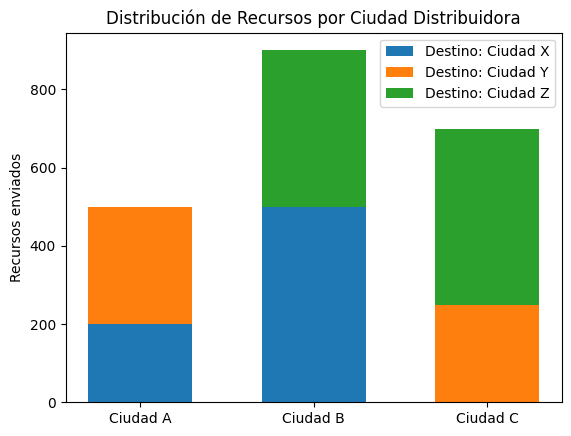

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# Datos de ejemplo
distribuidoras = ["Ciudad A", "Ciudad B", "Ciudad C"]
destinos = ["Ciudad X", "Ciudad Y", "Ciudad Z"]
asignaciones = np.array([[200, 300, 0], [500, 0, 400], [0, 250, 450]])  # Recursos enviados

x = np.arange(len(distribuidoras))
width = 0.6

fig, ax = plt.subplots()
bottom = np.zeros(len(distribuidoras))

for i, destino in enumerate(destinos):
    ax.bar(x, asignaciones[:, i], width, label=f"Destino: {destino}", bottom=bottom)
    bottom += asignaciones[:, i]

ax.set_ylabel("Recursos enviados")
ax.set_title("Distribución de Recursos por Ciudad Distribuidora")
ax.set_xticks(x)
ax.set_xticklabels(distribuidoras)
ax.legend()
plt.show()


In [37]:
offer = [550, 700]
costs = [
    [9999, 2.5],
    [2.5, 9999],
    [1.6, 2.0],
    [1.5, 1.0],
    [0.8, 1.0],
    [1.4, 0.8]
]
demand = [125, 175, 225, 250, 225, 200]

solver = TransportProblemSolver(costs, offer, demand)
solver.setup()
solver.solve()
solver.print_solution()

Desde 1 ciudad se ha sumistrado recursos hacia: 
	[->] destino 2 un total de 175.0 recursos (min: 175)
	[->] destino 3 un total de 225.0 recursos (min: 225)
	[->] destino 5 un total de 150.0 recursos (min: 225)
	---- STATS ----
	used: 550.0/550 from distribution city

Desde 2 ciudad se ha sumistrado recursos hacia: 
	[->] destino 1 un total de 125.0 recursos (min: 125)
	[->] destino 4 un total de 250.0 recursos (min: 250)
	[->] destino 5 un total de 75.0 recursos (min: 225)
	[->] destino 6 un total de 200.0 recursos (min: 200)
	---- STATS ----
	used: 650.0/700 from distribution city



# Punto 3

## 3.1. Matriz de cobertura

In [38]:
def generate_coverage_matrix(position, n=8):
    """
    Generates a dictionary representing the coverage of a queen placed at a given position on an n x n chessboard.

    Args:
        position (tuple): The (row, column) position of the queen.
        n (int): The size of the chessboard (default is 8 for standard chess).

    Returns:
        dict: A dictionary with keys as (i, j) positions and values as 1 if covered, 0 otherwise.
    """
    i, j = position
    coverage = {}

    # Mark row and column
    for k in range(1, n + 1):
        coverage[(i, k)] = 1
        coverage[(k, j)] = 1

    # Mark diagonals
    for k in range(1, n + 1):
        if 1 <= i + k <= n and 1 <= j + k <= n:
            coverage[(i + k, j + k)] = 1
        if 1 <= i - k <= n and 1 <= j - k <= n:
            coverage[(i - k, j - k)] = 1
        if 1 <= i + k <= n and 1 <= j - k <= n:
            coverage[(i + k, j - k)] = 1
        if 1 <= i - k <= n and 1 <= j + k <= n:
            coverage[(i - k, j + k)] = 1

    # The queen's own position
    coverage[(i, j)] = 1

    for i in range(n):
        for j in range(n):
            if (i,j) not in coverage:
                coverage[(i,j)] = 0

    return coverage

# Ejemplo de uso
position = (1, 1)  # Reina en la fila 3, columna 4
coverage = generate_coverage_matrix(position)

print(coverage)

{(1, 1): 1, (1, 2): 1, (2, 1): 1, (1, 3): 1, (3, 1): 1, (1, 4): 1, (4, 1): 1, (1, 5): 1, (5, 1): 1, (1, 6): 1, (6, 1): 1, (1, 7): 1, (7, 1): 1, (1, 8): 1, (8, 1): 1, (2, 2): 1, (3, 3): 1, (4, 4): 1, (5, 5): 1, (6, 6): 1, (7, 7): 1, (8, 8): 1, (0, 0): 0, (0, 1): 0, (0, 2): 0, (0, 3): 0, (0, 4): 0, (0, 5): 0, (0, 6): 0, (0, 7): 0, (1, 0): 0, (2, 0): 0, (2, 3): 0, (2, 4): 0, (2, 5): 0, (2, 6): 0, (2, 7): 0, (3, 0): 0, (3, 2): 0, (3, 4): 0, (3, 5): 0, (3, 6): 0, (3, 7): 0, (4, 0): 0, (4, 2): 0, (4, 3): 0, (4, 5): 0, (4, 6): 0, (4, 7): 0, (5, 0): 0, (5, 2): 0, (5, 3): 0, (5, 4): 0, (5, 6): 0, (5, 7): 0, (6, 0): 0, (6, 2): 0, (6, 3): 0, (6, 4): 0, (6, 5): 0, (6, 7): 0, (7, 0): 0, (7, 2): 0, (7, 3): 0, (7, 4): 0, (7, 5): 0, (7, 6): 0}


## 3.2. Modelo matematico

### Conjuntos
Se plantean los siguientes dos conjuntos.

- $F = \{1, 2, \dots, 8\}$ conjunto con las filas del tablero
- $C = \{1, 2, \dots, 8\}$ conjunto con las columnas del tablero

### Parámetros relevantes
En este caso el tamaño del tablero es un parámetro relevante ya que podemos definir este del tamaño que queramos $n \times m$. Sin embargo, para este caso se opta por tener un tablero de $8 \times 8$ para simplificar el problema. 

### Variable objetivo
Se define $X_{ij}$ como una matriz binaria de tamaño $8\times 8$ con $i \in F$ y $j \in C$. Esta matriz $X_{ij}$ será será 1 si hay una reina en esa posición y 0 de lo contrario.

### Función objetivo 
Se quiere minimizar el número de reinas que se ubican en el tablero de ajedrez. Por tanto,

$$
\min \sum_{i \in F} \sum_{j \in C} X_{ij}
$$

### Restricciones
- Cada casilla tiene que estar cubierta por lo menos por una reina.

$$
\sum_{k \in F} X_{k, j} + \sum_{k \in C} X_{i, k} + \sum_{k = 1}^{8} X_{i- k, j-k} + \sum_{k = 1}^{8} X_{i+ k, j+k} + \sum_{k = 1}^{8}X_{i- k, j+k} + \sum_{k = 1}^{8} X_{i+k, j-k} \geq 1 \,, \forall i \in F, j \in C \, | \, 1 \leq i \leq 8 \wedge 1 \leq j \leq 8
$$
<!--  -->
## Tipo de problema
Este problema es de programación lineal entera, las restricciones y la función objetivo son combinaciones lineales de la variable de decisión. Además, todo se mueve en el dominio de los enteros positivos (0 y 1). 

## 3.3. Modelo de Pyomo

In [39]:
# Definir el modelo
model = ConcreteModel()

# Conjuntos
n = 8  # Tamaño del tablero
model.F = RangeSet(1, n)
model.C = RangeSet(1, n)

# Variables de decisión
model.X = Var(model.F, model.C, within=Binary)  # 1 si hay una reina en (i, j)

# Función objetivo: minimizar el número de reinas
model.obj = Objective(expr=sum(model.X[i, j] for i in model.F for j in model.C), sense=minimize)

# Restricción de cobertura: cada casilla debe estar cubierta por al menos una reina
def cover_rule(model, i, j):
    return sum(model.X[k, j] for k in model.F) + \
           sum(model.X[i, k] for k in model.C) + \
           sum(model.X[i-k, j-k] for k in range(1, n) if 1 <= i-k <= n and 1 <= j-k <= n) + \
           sum(model.X[i+k, j+k] for k in range(1, n) if 1 <= i+k <= n and 1 <= j+k <= n) + \
           sum(model.X[i-k, j+k] for k in range(1, n) if 1 <= i-k <= n and 1 <= j+k <= n) + \
           sum(model.X[i+k, j-k] for k in range(1, n) if 1 <= i+k <= n and 1 <= j-k <= n) >= 1

model.cover_constraints = Constraint(model.F, model.C, rule=cover_rule)

# Resolver el modelo
solver = SolverFactory('glpk')
solver.solve(model)

{'Problem': [{'Name': 'unknown', 'Lower bound': 5.0, 'Upper bound': 5.0, 'Number of objectives': 1, 'Number of constraints': 64, 'Number of variables': 64, 'Number of nonzeros': 1520, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': '1031', 'Number of created subproblems': '1031'}}, 'Error rc': 0, 'Time': 1.1608881950378418}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

## 3.4. Resolución y análisis

El siguiente bloque de código se encarga de realizar la presentación de los resultados. También se ejecuto cambiando la lista de reinas seleccionadas y se muestra que todo efectivamente se cubre, tal y como se observa en la siguiente imagen.

<center>
<img src="./muestra.png" width="400px"/>
</center>

El resultado anterior muestra una solución válida al problema de cobertura mínima con reinas, donde solo cinco reinas han sido colocadas en posiciones para garantizar que todas las casillas del tablero estén cubiertas. La salida textual (el siguiente bloque de código que se ejecuta) confirma que la cobertura es completa, y la notación algebraica de las posiciones de las reinas coincide con la visualización. Esto sugiere que el modelo de optimización está funcionando correctamente y ha encontrado una solución óptima o cercana a la óptima en términos del número mínimo de reinas necesarias para este caso.

In [40]:
print("="*10 + " tablero " + "="*10)
for i in model.F:
    row = "".join("Q " if model.X[i, j].value == 1 else ". " for j in model.C)
    print(row)

mapper = {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h'}

l = [f"{mapper[j]}{9 - i}" for i in model.F for j in model.C if model.X[i,j].value == 1]
print()
print("="*10 + "selected queens" + "="*10)
print(l)

========== tablero ==========
Q . . . . . . . 
. . . . Q . . . 
. . . . . . Q . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. Q . . . . . . 
. . . . . Q . . 

==========selected queens==========
['a8', 'e7', 'g6', 'b2', 'f1']


In [41]:
!python ./queen_mapper.py

Traceback (most recent call last):
  File "c:\Users\laroc\OneDrive\Documentos\Universidad\MOS\Laboratorios\mos-labs\labs\lab3\queen_mapper.py", line 15, in <module>
    import pygame
ModuleNotFoundError: No module named 'pygame'


# Punto 4

## 4.1. Preprocesamiento y parametrización

En el preprocesamiento se plantea para lograr lo siguiente:

- Eliminar enlaces inválidos reduce el número de variables binaras $x_{ij}$ y restricciones. Esto hace que el modelo sea más eficiente.
- Si no filtramos correctamente los enlaces válidos, podríamos permitir conexiones inexistentes. Lo que nos llevaría a soluciones erróneas. Estructurar bien los conjuntos y parámetros antes de definir restricciones evita rutas no conectadas.
- La precomputación de distancias y la restricción anticiclo garantizan rutas válidas sin desviaciones innecesarias.

Como conclusion el preprocesamiento adecuado se nos permitirá obtener una solución óptima que respeta las restricciones del problema.

## 4.2. Formulación del modelo matemático

### Conjuntos 

Definiremos 2 conjuntos para resolver este problema:
- $N$: Conjunto de nodos en la red, donde $N = (1,2,3,4,5,6,7)$
- $A$: Conjunto de enlaces entre nodos, donde existe un enlace $(i,j) \in A$ si la distancia euclidianda $d_{ij} \le 20$

### Parametros relevantes

Consideramos necesario tener los siguientes parametros para este ejercicio:

- $c_{ij}$: Costo del enlace entre los nodos $i$ y $j$, definido como la distancia euclidiana entre ellos si $(i,j) \in A$, de lo contrario es infinito o un valor suficientemente grande (Big M).
- $s_i$: Parametro de suministro/demanda en cada nodo, donde $s_i$ puede tomar los valores
    - 1, si $i =4$(nodo origen)
    - -1, si $i=6$(nodo destino)
    - 0, de lo contrario

### Variable de decisión
Como variables de decision vamos a definir: 
- $x_{ij}$: Variable binaria que indica si el enlace $(i,j)$ se usa en la ruta óptima.
   - el valor puede ser 1, si el enlace $(i,j)$ es parte de la ruta, o $0$ en otro caso 

- Ademas definimos $f_{i,j}$ para saber el flujo de datos del enlace $(i,j)$

- Por ultimo $u_i$ representa la prosicion del nodo $i$ en la ruta


### Función objetivo

Nuestro objetivo en este problema, es poder minimizar el costo toal de la ruta iniciando en el nodo 4 hasta el nodo 6. 

$$ \min \sum_{(i,j) \in A} c_{ij}x_{ij} $$

### Restricciones

Se proponen las siguientes restricciones: 

1. Se debe conservar el flujo de todos los nodos, excepto en el origen y el destino. Todo lo que entra deber ser igual a lo que sale:
$$ \sum_{(i,j) \in A} f_{ij} - \sum_{(j,i) \in A} f_{ji} = s_i, \forall i \in N$$
2. Un enlace solo puede transportar flujo si está seleccionado en la ruta: 
$$ 0 \leq f_{ij} \leq x_{ij}, \forall (i,j) \in A$$
3. cada nodo puede estar conectado a lo sumo a un nodo siguiente en la ruta 
$$ \sum_{(i,j) \in A} x_{ij} \leq 1, \forall i \in N, i \neq 6 $$
4. La cantidad de flujo total que sale del nodo origen debe ser igual a 1, lo que nos indica que hay una unica ruta de conexion:
$$ \sum_{(4,j) \in A} f_{4j} = 1$$
5. Para prevenir que se generen ciclos en la ruta usamos la siguiente restriccion: 
$$ u_i - u_j +1 \leq (|N| - 1)(1-x_{ij}), \forall(i,j) \in A, i \neq 4, j \neq 6$$

### Tipo de problema

Como podemos observar, este problema se trata de un camino minimo en un grafo con restricciones de flujo por lo que puede modelarse como un problema de programación lineal entera mixta (MILP). La funcion objetivo y las restricciones son lineales, pero la presencia de variables binarias hace que sea un problema de optimización conbinatoria.

## 4.3. Implementación en Pyomo

In [42]:
N = {1, 2, 3, 4, 5, 6, 7}  # Conjunto de nodos
coordenadas = {
    1: (20, 6), 2: (22, 1), 3: (9, 2), 4: (3, 25),
    5: (21, 10), 6: (29, 2), 7: (14, 12)
}

A = set()  # Conjunto de enlaces válidos
c = {}  # Matriz de costos

for i in N:
    for j in N:
        if i != j:
            d = np.linalg.norm(np.array(coordenadas[i]) - np.array(coordenadas[j]))
            if d <= 20:
                A.add((i, j))
                c[i, j] = d

s = {i: 0 for i in N}
s[4] = 1  # Nodo de origen
s[6] = -1  # Nodo de destino

In [43]:
model = ConcreteModel()

# Variables de decisión
model.x = Var(A, within=Binary)  # Si se usa el enlace
model.f = Var(A, within=NonNegativeReals)  # Flujo en el enlace
model.u = Var(N, within=Integers, bounds=(1, len(N)))  # Orden de los nodos

def obj_rule(model):
    return sum(c[i, j] * model.x[i, j] for (i, j) in A)
model.obj = Objective(rule=obj_rule, sense=minimize)

# Conservación de flujo
def flow_conservation_rule(model, i):
    return sum(model.f[i, j] for j in N if (i, j) in A) - sum(model.f[j, i] for j in N if (j, i) in A) == s[i]
model.flow_conservation = Constraint(N, rule=flow_conservation_rule)

# Relación entre flujo y enlaces activos
def flow_activation_rule(model, i, j):
    return model.f[i, j] <= model.x[i, j]
model.flow_activation = Constraint(A, rule=flow_activation_rule)

# Conectividad (máximo un sucesor)
def connectivity_rule(model, i):
    if i != 6:  # No aplica para el nodo destino
        return sum(model.x[i, j] for j in N if (i, j) in A) <= 1
    return Constraint.Skip
model.connectivity = Constraint(N, rule=connectivity_rule)

# Flujo total desde el nodo de origen
def source_flow_rule(model):
    return sum(model.f[4, j] for j in N if (4, j) in A) == 1
model.source_flow = Constraint(rule=source_flow_rule)

# Restricción para evitar ciclos
def no_cycle_rule(model, i, j):
    if i != 4 and j != 6:
        return model.u[i] - model.u[j] + 1 <= (len(N) - 1) * (1 - model.x[i, j])
    return Constraint.Skip
model.no_cycles = Constraint(A, rule=no_cycle_rule)

In [44]:
solver = SolverFactory('glpk')
result = solver.solve(model)

# Mostrar resultados
print("\nRuta óptima:")
for (i, j) in A:
    if model.x[i, j]() > 0.5:
        print(f"{i} -> {j}")

print("\nCosto total mínimo:", model.obj())


Ruta óptima:
7 -> 6
4 -> 7

Costo total mínimo: 35.057142743246345


## 4.4. Análisis de resultados

La solución obtenida indica que la ruta de menor costo entre el nodo **4 (origen)** y el nodo **6 (destino)** es:  

**4 → 7 → 6**  

con un costo total de **35.06 unidades**.  

### Verificación de enlaces

Usamos la fórmula de distancia Euclidiana:  

$$ d_{ij} = \sqrt{(X_i - X_j)^2 + (Y_i - Y_j)^2} $$

- **Distancia entre 4 y 7**: $$d_{4,7} = \sqrt{(3 - 14)^2 + (25 - 12)^2} \approx 17.03 $$
- **Distancia entre 7 y 6**:$$d_{7,6} = \sqrt{(14 - 29)^2 + (12 - 2)^2} \approx 18.03 $$

Ambos enlaces cumplen la restricción $ d_{ij} \leq 20 $, por lo que la solución es válida.  

### Importancia del preprocesamiento

- Eliminar enlaces inválidos reduce el número de variables binaras $x_{ij}$ y restricciones.
- Esto hace que el modelo sea más eficiente.
- Si no filtramos correctamente los enlaces válidos, podríamos permitir conexiones inexistentes. Loque nos llevaría a soluciones erróneas.
- Estructurar bien los conjuntos y parámetros antes de definir restricciones evita rutas no conectadas.
- La precomputación de distancias y la restricción anti-ciclo garantizan rutas válidas sin desviaciones innecesarias.

Como conclusion el preprocesamiento adecuado permitió obtener una solución óptima que respeta las restricciones del problema.
Facilitó la correcta formulación del modelo matemático y aseguró rutas viables con eficiencia.

# Punto 5

## Conjuntos
Se plantean los siguientes conjuntos:

- $ V = \{0, 1, 2, \dots, n\} $ conjunto de localidades, donde $ 0 $ es la localidad de partida.
- $ K = \{1, 2, \dots, m\} $ conjunto de equipos de inspección.
- $ E = \{(i, j) \mid i, j \in V, i \neq j\} $ conjunto de aristas que representan conexiones entre localidades.

## Parámetros
- $ c_{ij} $: Costo (distancia o tiempo) de viajar desde la localidad $ i $ a la localidad $ j $.
- $ n $: Número total de localidades.
- $ m $: Número de equipos disponibles.

## Variables de decisión
Para el problema del viajante único:
- $ x_{ij} $ = 1 si se viaja de la localidad $ i $ a la localidad $ j $, 0 en caso contrario.
- $ u_i $ representa el orden de visita de la localidad $ i $ (para evitar subtours).

Para la extensión a múltiples equipos:
- $ x_{ij}^k $ = 1 si el equipo $ k $ se mueve de la localidad $ i $ a la localidad $ j $, 0 en caso contrario.
- $ u_i^k $ representa el orden de visita de la localidad $ i $ por el equipo $ k $.

## Función objetivo
Se busca minimizar el costo total de desplazamiento:

$$
\min \sum_{(i,j) \in E} c_{ij} x_{ij}
$$

Para múltiples equipos:

$$
\min \sum_{k \in K} \sum_{(i,j) \in E} c_{ij} x_{ij}^k
$$

## Restricciones

### Restricción de visita única
Cada localidad debe ser visitada exactamente una vez por un equipo:

$$
\sum_{k \in K} \sum_{j \in V, j \neq i} x_{ij}^k = 1, \quad \forall i \in V \setminus \{0\}
$$

### Restricción de inicio y fin en la localidad 0
Cada equipo comienza y finaliza su recorrido en la localidad 0:

$$
\sum_{j \in V, j \neq 0} x_{0j}^k = 1, \quad \forall k \in K
$$

$$
\sum_{i \in V, i \neq 0} x_{i0}^k = 1, \quad \forall k \in K
$$

### Restricción de continuidad del recorrido (flujo de entrada y salida)
Cada localidad, excepto la de partida, debe tener exactamente un camino de entrada y un camino de salida:

$$
\sum_{j \in V, j \neq i} x_{ij}^k - \sum_{j \in V, j \neq i} x_{ji}^k = 0, \quad \forall i \in V, k \in K
$$

### Eliminación de subtours (MTZ constraints)
Para evitar ciclos dentro del recorrido:

$$
u_i - u_j + n x_{ij}^k \leq n - 1, \quad \forall i, j \in V, i \neq j, i \neq 0, j \neq 0, k \in K
$$

$$
1 \leq u_i^k \leq n-1, \quad \forall i \in V, i \neq 0, k \in K
$$

### Restricción de no negatividad y variables binarias
$$
x_{ij}^k \in \{0,1\}, \quad \forall (i,j) \in E, k \in K
$$

$$
u_i^k \geq 0, \quad \forall i \in V, k \in K
$$


In [45]:
#Importacion de librerias y lectura de datos 
import pyomo.environ as pyo
import pandas as pd
import numpy as np

# Cargar la matriz de costos desde el archivo CSV
file_path = r"./cost_matrix_5_nodes_2.5_spread.csv"  # Ajusta la ruta si es necesario
cost_matrix = pd.read_csv(file_path, header=None).values

# Número de localidades (nodos)
n = cost_matrix.shape[0]  # Se asume que la matriz es cuadrada

# Definir conjunto de nodos V
V = range(n)


In [46]:
# Definición del modelo 
model = pyo.ConcreteModel()

# Conjunto de nodos
model.V = pyo.Set(initialize=range(5))  # Adjusted to match the size of cost_matrix

# Conjunto de aristas (pares de nodos sin repetición i ≠ j)
model.E = pyo.Set(dimen=2, initialize={(i, j) for i in range(5) for j in range(5) if i != j})

# Parámetros de costos de viaje entre localidades
model.c = pyo.Param(model.E, initialize={(i, j): cost_matrix[i][j] for (i, j) in model.E})


In [47]:
# Variables de decisión

# Variable binaria x_ij = 1 si se viaja de i a j, 0 en caso contrario
model.x = pyo.Var(model.E, within=pyo.Binary)

# Variables auxiliares u_i para evitar subtours
model.u = pyo.Var(model.V, within=pyo.NonNegativeIntegers, bounds=(1, n-1))


In [48]:
# Función objetivo: Minimizar la suma de costos de viaje
def objective_function(model):
    return sum(model.c[i, j] * model.x[i, j] for i, j in model.E)

model.obj = pyo.Objective(rule=objective_function, sense=pyo.minimize)


In [49]:
#Restricciones
def visit_once_rule(model, i):
    if i != 0:  # Excluye la localidad de partida
        return sum(model.x[j, i] for j in model.V if (j, i) in model.E) == 1
    return pyo.Constraint.Skip

model.visit_once = pyo.Constraint(model.V, rule=visit_once_rule)

def leave_once_rule(model, i):
    if i != 0:
        return sum(model.x[i, j] for j in model.V if (i, j) in model.E) == 1
    return pyo.Constraint.Skip

model.leave_once = pyo.Constraint(model.V, rule=leave_once_rule)

def start_and_end_rule(model):
    return sum(model.x[0, j] for j in model.V if (0, j) in model.E) == 1

model.start = pyo.Constraint(rule=start_and_end_rule)

def end_rule(model):
    return sum(model.x[i, 0] for i in model.V if (i, 0) in model.E) == 1

model.end = pyo.Constraint(rule=end_rule)

def subtour_elimination_rule(model, i, j):
    if i != 0 and j != 0 and i != j:
        return model.u[i] - model.u[j] + (n - 1) * model.x[i, j] <= n - 2
    return pyo.Constraint.Skip

model.subtour = pyo.Constraint(model.E, rule=subtour_elimination_rule)


In [50]:
# Solucion 
solver = pyo.SolverFactory('glpk')

# Resolver el modelo
solver.solve(model, tee=True)

# Obtener la solución óptima
solution_edges = [(i, j) for i, j in model.E if pyo.value(model.x[i, j]) > 0.5]

print("Rutas óptimas:")
for edge in solution_edges:
    print(f"Localidad {edge[0]} → Localidad {edge[1]}")


GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\laroc\AppData\Local\Temp\tmpkwx5u9fq.glpk.raw --wglp C:\Users\laroc\AppData\Local\Temp\tmpvf91biih.glpk.glp
 --cpxlp C:\Users\laroc\AppData\Local\Temp\tmpycgj1t0g.pyomo.lp
Reading problem data from 'C:\Users\laroc\AppData\Local\Temp\tmpycgj1t0g.pyomo.lp'...
C:\Users\laroc\AppData\Local\Temp\tmpycgj1t0g.pyomo.lp:197: warning: lower bound of variable 'x2' redefined
C:\Users\laroc\AppData\Local\Temp\tmpycgj1t0g.pyomo.lp:197: warning: upper bound of variable 'x2' redefined
22 rows, 24 columns, 76 non-zeros
24 integer variables, 20 of which are binary
217 lines were read
Writing problem data to 'C:\Users\laroc\AppData\Local\Temp\tmpvf91biih.glpk.glp'...
167 lines were written
GLPK Integer Optimizer 5.0
22 rows, 24 columns, 76 non-zeros
24 integer variables, 20 of which are binary
Preprocessing...
22 rows, 24 columns, 76 non-zeros
24 integer variables, 20 of which are binary
Scaling...
 A: min|aij| =